In [8]:
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import transforms as transforms

from facial_keypoints_dataset import FacialKeypointsDataset
from face_mobilenetv2 import (
    DummyKeypointModel,
    FinalKeypointModel
)


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
hparams = {
    'batch_size' : 32,
    'learning_rate' : 0.0004
}  

In [10]:
loaded_model = FinalKeypointModel(hparams)

torch.Size([32, 3, 224, 224])
torch.Size([32, 30])


In [40]:
loaded_model.eval()

FinalKeypointModel(
  (cnn): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=

In [11]:
loaded_model.load_state_dict(torch.load('mobilenetv2_single_classif_layer.pt'))

<All keys matched successfully>

In [47]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [141]:
preprocess= transforms.Compose([
  transforms.ToPILImage(),
  transforms.Resize((96,96)),
  transforms.Resize((224,224)),
  transforms.ToTensor(),
  transforms.Lambda(lambda x: x.expand((3,224,224))),
  transforms.Normalize((0.485, 0.456, 0.406) ,(0.229, 0.224, 0.225))
])   #This is necessary in order to use the pretrained model's feature extractors (Conv. layers)

In [45]:
unprocess =  transforms.Compose([
  transforms.Lambda(lambda x: UnNormalize(mean=(0.485, 0.456, 0.406) ,std=(0.229, 0.224, 0.225))(x)),                     
  transforms.Lambda(lambda x: x[0].unsqueeze(0)),
  transforms.ToPILImage(),
  transforms.Resize((96,96)),
  transforms.ToTensor()
])

In [22]:
download_url = 'http://filecremers3.informatik.tu-muenchen.de/~dl4cv/training.zip'
i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(i2dl_exercises_path, "datasets", "facial_keypoints")
train_dataset = FacialKeypointsDataset(
    train=True,
    transform=preprocess,
    root=data_root,
    download_url=download_url
)
val_dataset = FacialKeypointsDataset(
    train=False,
    transform=preprocess,
    root=data_root,
)
print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))

0it [00:00, ?it/s]

100%|████████████████████████████████████████████████████████████████▋| 66158592/66454392 [00:17<00:00, 4426006.76it/s]

Number of training samples: 1546
Number of validation samples: 298


66461696it [00:29, 4426006.76it/s]                                                                                     

In [42]:
import matplotlib.pyplot as plt


def show_all_keypoints(image, keypoints, pred_kpts=None):
    """Show image with predicted keypoints"""
    image = (image.clone() * 255).view(96, 96)
    plt.imshow(image, cmap='gray')
    keypoints = keypoints.clone() * 48 + 48
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=200, marker='.', c='m')
    if pred_kpts is not None:
        pred_kpts = pred_kpts.clone() * 48 + 48
        plt.scatter(pred_kpts[:, 0], pred_kpts[:, 1], s=200, marker='.', c='r')
    plt.show()

In [43]:
def show_keypoint_predictions_test(model, dataset, num_samples=3):
    indices = []
    for f in range(num_samples):
        i = torch.randint(0,len(dataset),(1,)).numpy()[0]
        indices.append(i)
        #image = dataset[i]["image"]
        #key_pts = dataset[i]["keypoints"]
        image = dataset[i][0]
        key_pts = dataset[i][1]
        predicted_keypoints = torch.squeeze(model(image).detach()).view(15,2)
        show_all_keypoints(unprocess(image), key_pts, predicted_keypoints)
    return indices

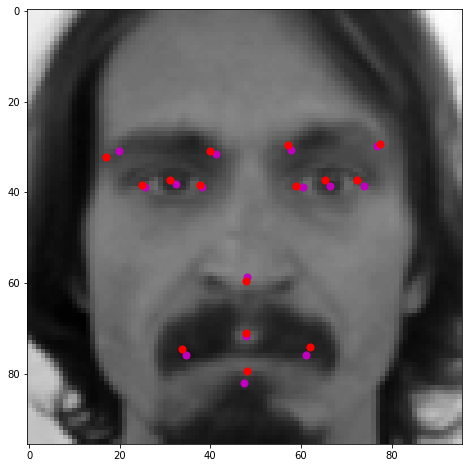

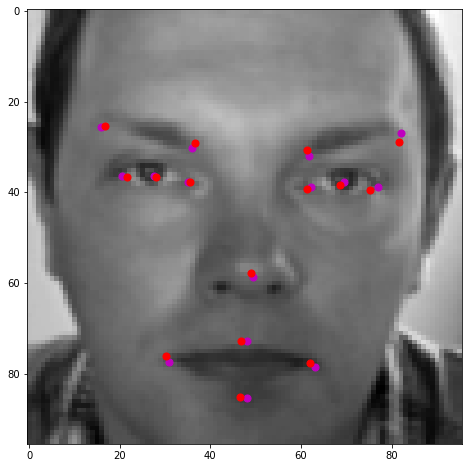

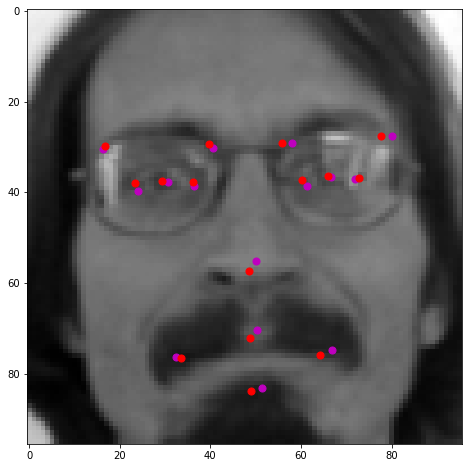

In [59]:
indices = show_keypoint_predictions_test(loaded_model, val_dataset)

In [130]:
def show_all_predicted_keypoints(image, keypoints, pred_kpts=None):
    """Show image with predicted keypoints"""
    #image = (image.clone() * 255).view(96, 96)
    print(image.size())
    plt.figure()
    plt.imshow(image[0], cmap='gray')
    keypoints = keypoints.clone() * 48 + 48
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=200, marker='.', c='m')
    if pred_kpts is not None:
        pred_kpts = pred_kpts.clone() * 48 + 48
        plt.scatter(pred_kpts[:, 0], pred_kpts[:, 1], s=200, marker='.', c='r')
    plt.show()

In [142]:
preprocess_webcam= transforms.Compose([
  transforms.ToPILImage(),
  transforms.Resize((96,96)),
  transforms.ToTensor(),
  #transforms.Lambda(lambda x: x.unsqueeze(0))
])   #This is necessary in order to use the pretrained model's feature extractors (Conv. layers)

In [150]:
def mark_custom_image(name, model = loaded_model): #shows the grayscale image captured by us
    image = plt.imread(name)  #read a grayscale jpg as 3 channel image for some reason (each channel same)
    print(image.shape)
    image = image[:,:,0]
    print(image.shape)
    
    plt.figure()
    plt.imshow(image)
    
    image_tensor = preprocess(torch.from_numpy(image))
    #image_tensor = preprocess(image_tensor)
    print(image_tensor.size())
    
    print(image_tensor.min())
    print(image_tensor.max())
    
    plt.figure()
    plt.imshow(image_tensor[0].detach().numpy())
    
    predicted_keypoints = torch.squeeze(model(image_tensor).detach()).view(15,2)
    print(type(image_tensor))
    show_all_predicted_keypoints(preprocess_webcam(image_tensor[0]), predicted_keypoints)

(149, 149, 3)
(149, 149)
torch.Size([3, 224, 224])
tensor(-2.1179)
tensor(2.4483)
<class 'torch.Tensor'>
torch.Size([1, 96, 96])


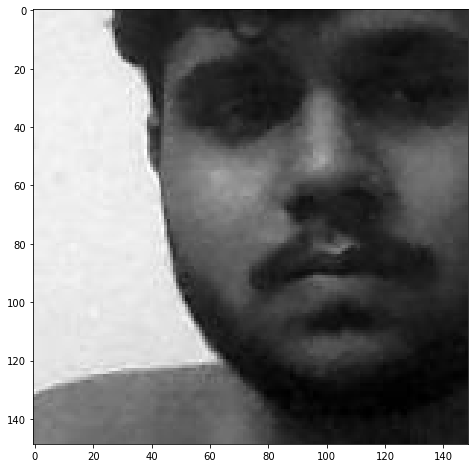

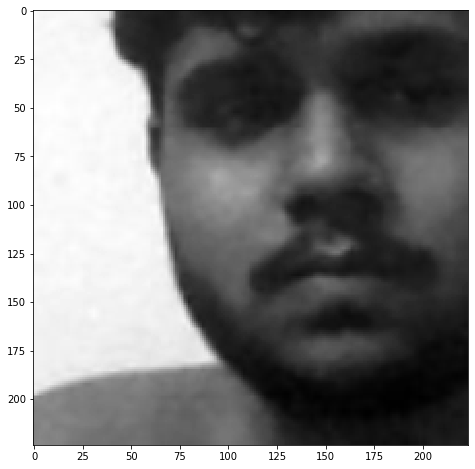

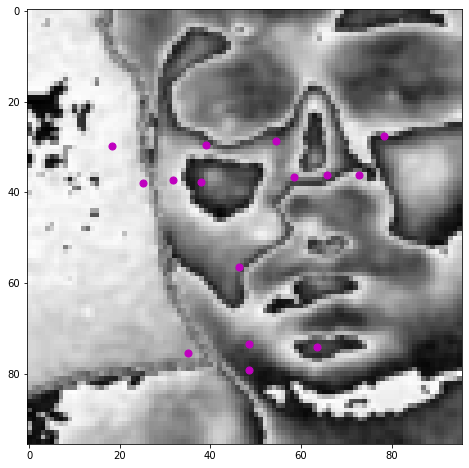

In [152]:
mark_custom_image('my_face.jpg')